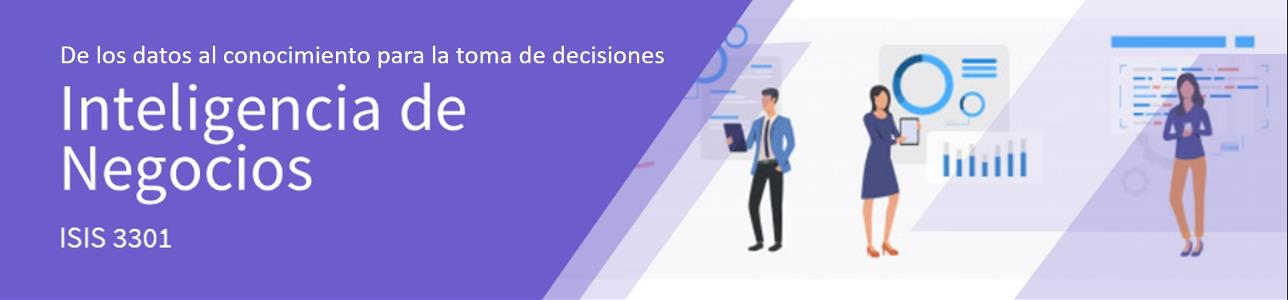

## Problema de negocio

La asociación está interesada en los siguientes objetivos:
1.	Analizar las características de sitios turísticos que los hacen atractivos. Es decir, se deben poder seleccionar las palabras clave que confiablemente predigan la calificación que tendrá la reseña.
2.	Predecir la calificación que tendrá una reseña con base en su contenido textual.
3.	Utilizar las predicciones de calificaciones para identificar oportunidades de mejora que permitan aumentar la popularidad de los sitios y fomentar el turismo.

Criterios de éxito:
1.	Tener un sistema de software que pueda procesar 1000 reseñas por hora y pueda definir automáticamente la calificación que tendrá una reseña, con una precisión mínima del 70%. 
2.	Considerar por lo menos tres (3) modelos con distintos algoritmos para encontrar el mejor modelo posible.

El impacto en Colombia se define más adelante.


_Modelo_: El enfoque propuesto es la clasificación de reseñas y la predicción de calificaciones de reseñas. Esto implica que se desea clasificar las reseñas en diferentes categorías o clases y predecir la calificación.

_Técnica_: Clasificador Bayes ingenuo (gaussiano y multinomial), Support Vector Machines, Regresion Logistica:
	
El clasificador gaussiano Bayes ingenuo asume independencia condicional entre las características dadas las clases, y utiliza la distribución gaussiana para modelar las características. El método multinomial supone todo lo anterior, pero utiliza una distribución multinomial y se aplica a datos discretos. Ambas técnicas se considerarán bajo el mismo numeral dado su cercanía teórica en implementación. 

Las Support Vector Machines (Máquinas de Vectores de Soporte) son modelos de aprendizaje supervisado que pueden ser utilizados tanto para clasificación como para regresión. La idea básica de SVM es encontrar el hiperplano óptimo que mejor separa las clases en el espacio de características.
	

_Justificación_: se eligió este tipo de modelo por diversas razones. Primero, se cuenta con un dataset etiquetado y otro no etiquetado que se desea etiquetar. Segundo, las etiquetas corresponden a datos numéricos que se conocen de antemano y se pueden considerar discretos dada su baja cardinalidad (|{1,2,3,4,5}|=5). Con esto se eligió un modelo de clasificación y predicción. Adicionalmente, como se desea conocer los criterios de clasificación, se eligieron técnicas de clasificación que permitan ver estas elecciones.


### 1. Instalación e importación de librerías.


In [810]:
# Actualizaciones necesarias
!python -m pip install --upgrade pip
!pip install --upgrade setuptools

In [811]:
# Instalación de todas las librerías necesarias
!pip install -r ../requirements.txt

In [812]:
# librería Natural Language Toolkit, usada para trabajar con textos
import nltk
# Punkt permite separar un texto en frases.
nltk.download('punkt')
# Descarga todas las palabras vacias, es decir, aquellas que no aportan nada al significado del texto
nltk.download('stopwords')
# Descarga de paquete WordNetLemmatizer, este es usado para encontrar el lema de cada palabra
# ¿Qué es el lema de una palabra? ¿Qué tan dificil puede ser obtenerlo, piensa en el caso en que tuvieras que escribir la función que realiza esta tarea?
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alvar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alvar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alvar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [813]:
# Instalación de librerias
import pandas as pd
import numpy as np
import sys

import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, accuracy_score, recall_score
from sklearn.linear_model import LogisticRegression
from ydata_profiling import ProfileReport

from sklearn.base import BaseEstimator, ClassifierMixin

import matplotlib.pyplot as plt

import stanza

from copy import deepcopy
from math import floor

### 2. Perfilamiento y entendimiento de los datos



#### Lectura de los datos.

In [814]:
# Uso de la libreria pandas para la lectura de archivos
data=pd.read_csv('../data/raw/tipo2_entrenamiento_estudiantes.csv', sep=',', encoding = 'utf-8')
# Asignación a una nueva variable de los datos leidos
data_t=deepcopy(data)

In [815]:
data_t

,Review,Class
0,Muy buena atención y aclaración de dudas por p...,5
1,Buen hotel si están obligados a estar cerca de...,3
2,"Es un lugar muy lindo para fotografías, visite...",5
3,Abusados con la factura de alimentos siempre s...,3
4,Tuvimos un par de personas en el grupo que rea...,3
...,...,...
7870,"Me parece buen sistema, agiliza el transporte,...",4
7871,"Fue una escapada de un día desde el complejo, ...",4
7872,La Plaza de la Revolución es un lugar emblemát...,3
7873,Es la segunda ocasión que me quedo en los cuar...,1


In [816]:
data_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7875 entries, 0 to 7874
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  7875 non-null   object
 1   Class   7875 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 123.2+ KB


#### Entendimiento de los datos
El número de reseñas recogidas fue de 7875. Se cuenta con dos columnas, “Review” y “Class”. A estos datos se les añadieron las columnas “Conteo”, “Max” y “Min” para contar el número de palabras, encontrar la palabra más larga y la más corta, por reseña, respectivamente. La columna “Review” corresponde a textos (strings) con longitudes de entre 2 y 1809 palabras. Con respecto a la longitud de las palabras, estas van desde 1 carácter hasta 76 caracteres.

Por otra parte, la columna “Class” contiene las calificaciones, numéricas, entre 1 y 5. Es evidente la no uniformidad en esta columna. Adicionalmente hay un mayor número de calificaciones de 5 (2361) y muy pocas calificaciones de 1 (778). Esto se tomará en cuenta a la hora de preparar los datos. 


In [817]:
textos = data_t.copy()
textos['Conteo'] = [len(x.split()) for x in textos['Review']]
#textos['Moda'] =
textos['Max'] = [max([len(w) for w in x.split()]) for x in textos['Review']]
textos['Min'] = [min([len(w) for w in x.split()]) for x in textos['Review']]

# Se realiza un perfilamiento de los datos con la librería pandas profiling
ProfileReport(textos)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Por último, es importante resaltar la correlación que existe entre la longitud de una reseña (medida en número de palabras) y la calificación otorgada. Es importante resaltar que no se hallaron datos nulos o celdas vacías, pero sí 29 filas duplicadas.

### 3. Preparación de datos

#### **3.1. Preprocesamiento Stanza (tokenización + lematización)**
Teniendo en cuenta las dificultades de usar las herramientas de NLTK en español, se propone un nuevo pipeline utilizando la librería Stanza. Dado que la lematización funciona mejor con un contexto sintáctico (es decir, con oraciones en español), este proceso **junto a la tokenización** se realizarán antes de la limpieza general.

In [818]:
# stanza pipeline is created in Spanish
stanza_pipeline = stanza.Pipeline(lang="es", processors="tokenize,mwt,pos,lemma")

def stanza_preprocessing(words):
    """
    Uses the Stanza Pipeline to preprocess text
    Recommended before cleaning as stopword eliminations, lower-casing
    and punctuation removal affect POS and word tagging for lemma resolution
    
    :param words: (list) unclean words passed through the pipeline
    :param pipe: (stanza.Pipeline) stanza Pipeline used
    :return: (list) lemmas obtained
    """
    doc = stanza_pipeline(words)
    lemmas = [w.lemma for w in doc.sentences[0].words]
    return lemmas


2024-04-07 18:16:04 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-04-07 18:16:05 INFO: Downloaded file to C:\Users\alvar\stanza_resources\resources.json
2024-04-07 18:16:06 INFO: Loading these models for language: es (Spanish):
| Processor | Package         |
-------------------------------
| tokenize  | ancora          |
| mwt       | ancora          |
| pos       | ancora_charlm   |
| lemma     | ancora_nocharlm |

2024-04-07 18:16:06 INFO: Using device: cpu
2024-04-07 18:16:06 INFO: Loading: tokenize
2024-04-07 18:16:06 INFO: Loading: mwt
2024-04-07 18:16:06 INFO: Loading: pos
2024-04-07 18:16:07 INFO: Loading: lemma
2024-04-07 18:16:07 INFO: Done loading processors!


#### **3.2. Limpieza de los datos**
Habiendo tokenizado y lematizado, se procede a hacer una limpieza general. Esta incluye los siguientes pasos:

**Eliminación de reseñas duplicadas**: las 29 reseñas duplicadas son perjudiciales para el modelo sin saber en qué contexto se dan. Nótese que más adelante se pueden usar duplicados bajo la necesidad de sobre muestreo.

**Eliminación de reseñas de longitud atípica**: las reseñas muy largas pueden causar overfitting sobre sus vectorizaciones demasiado completas. Asimismo, aumentan el tiempo de ejecución del algoritmo. Por otra parte, las reseñas muy cortas pueden sobrevalorar ciertas palabras como indicadores de calificación. Por lo tanto, se tomará el percentil de 90% del medio de las reseñas por longitud.

**Conversión de caracteres a codificación estándar**: se cambió de 'ascii' a 'utf-8' para incluir acentos claves en español. Adicionalmente, si el modelo se extiende a otros lenguajes (principalmente romance), esta codificación sigue siendo válida.

**Conversión a minúsculas**: se mantiene igual. Usa el default de Python.

**Eliminación de puntuación**: se mantiene igual.

**Eliminación de stopwords**: se usan stopwords en español. Se deben descargar nuevas listas de acuerdo a la expansión a otros lenguajes. Nótese que las contracciones se incluyen como stopwords en español, así que estás quedan cubiertas por este paso. 


In [819]:
def atypical_length(df, alfa, beta):
    """
    Elimina las reseñas con un bajo número de palabras dado que no son dicientes
    
    :param df: (DataFrame) reseñas y califiaciones de los usuarios
    :param alfa: (float) porcentaje en cola izquierda excluido
    :param alfa: (float) porcentaje en cola derecha excluido
    :return: (DataFrame) elimina las entradas con menos palabras que el umbral dado
    """
    
    df_longitudes = df.copy()
    df_longitudes['Conteo'] = [len(x.split()) for x in df_longitudes['Review']]
    
    upper = df_longitudes['Conteo'].quantile(1-beta)
    lower = df_longitudes['Conteo'].quantile(alfa)
    
    chosen = df_longitudes[df_longitudes['Conteo'] > lower]
    chosen = chosen[chosen['Conteo'] < upper]
    
    #print("Mínimo número palabras: ", min(chosen['Conteo']))
    #print("Máximo número palabras: ", max(chosen['Conteo']))
    
    chosen = chosen.drop(columns=['Conteo'])
    
    return chosen


def remove_duplicates(df):
    """
    Elimina las reseñas duplicadas en la columna Review
    
    :param df: dataframe a manipular
    :return: 
    """
    return df.drop_duplicates()
    

def remove_non_ascii(words):
    """
    Remueve caractéres no ASCII de la lista de palabras tokenizadas
    
    :param words: (list) lista de palabras tokenizadas
    :returns: (list) lista de palabras/strings 'ASCII-zadas'
    """
    # TODO: reconsiderar entre ASCII y UTF-8
    new_words = []
    for word in words:
        if word is not None:
            # debe ser codificado en UTF-8 para no obstaculizar al lematizador
          new_word = unicodedata.normalize('NFKD', word).encode('utf-8', 'ignore').decode('utf-8', 'ignore')
          new_words.append(new_word)
    return new_words


def to_lowercase(words):
    """
    Convierte todos los caracteres a minúscula de la lista de palabras tokenizadas
    
    :param words: (list) lista de palabras tokenizadas
    :returns: (list) lista de palabras en minúscula
    """
    return [w.lower() for w in words]


def remove_punctuation(words):
    """
    Remove punctuation from list of tokenized words
    
    :param words: (list) lista de palabas
    :returns: (list) lista de palabras con puntuación removida
    """
    new_words = []
    for word in words:
        if word is not None:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
    return new_words


#def replace_numbers(words):
#    """Replace all interger occurrences in list of tokenized words with textual representation"""
#    p = inflect.engine()
#    print(words)
#    new_words = []
#    for word in words:
#        if word.isdigit():
#            new_word = p.number_to_words(word)
#            new_words.append(new_word)
#            print("if " + new_word)
#        else:
#            new_words.append(word)
#    return new_words


def remove_stopwords(words):
    """
    Remueve las stop words de la lista de palabras tokenizadas
    
    :param words: (list) lista de palabras tokenizadas
    :returns: (list) lista de palabras sin stop words
    """
    
    # TODO english is eliminated as it is not part of the reviews. Must check if this is true 
    languages = ['spanish']
    stopword = nltk.corpus.stopwords.words(languages)
    
    # in case of only spanish, contractions are included as stopwords
    return [w for w in words if w not in stopword]
    
    
def separate_contractions(words):
    """
    Elimina las contracciones. Cubre inglés, las contracciones en español están cubiertas
    con las stopwords
    
    :param words: lista de palabras tokenizadas
    :return: lista de palabras sin contracciones
    """
    return words.apply(contractions.fix)


# se renombra el preprocessing como cleaning
def cleaning(words):
    words = to_lowercase(words)
#    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
#    words = separate_contractions(words)
    return words


#### **3.3. Guardado de datos parciales**
Luego de la realización de pruebas preliminares, se halló que las funciones de Stanza son demoradas y pueden tomar hasta varias horas de ejecución. Por lo tanto, se tomó la decisión de guardar los datos procesados para ahorrar este proceso. Estos serán cargados de nuevo para el entrenamiento.

In [820]:
def save_processed_data(df, file_name)->None:
    """
    Guarda los datos procesados en un archivo .csv para ser cargados posteriormente
    
    :param df: (DataFrame) datos procesados
    :param file_name: (str) nombre del archivo a guardarlo. Sin extensión, se supone .csv 
    """
    file_path = "../data/processed/" + file_name + ".csv"
    
    df.to_csv(file_path, sep=';', index=False)
    

#### **3.5. Vectorización**
Habiendo realizado la tokenización, lematización y limpieza, se procede a vectorizar los datos para que sean compatibles con los modelos de _machine learning_.

In [821]:
def vectorize(data: pd.DataFrame, feature_vectorizer_algorithm, objective_vectorizer_algorithm)->tuple:
    """
    Vectoriza las features utilizando el algoritmo provisto
    
    :param data: data frame de datos procesados
    :param feature_vectorizer_algorithm: algoritmo de vectorización a utilizar para features
    :param objective_vectorizer_algorithm: algoritmo de vectorización a utilizar para objetivo
    :return: (lista de números correspondientes a la vectorización, arreglo de features)
    """
    data_stringfied = deepcopy(data)
    data_stringfied['Review'] = data_stringfied['Review'].apply(lambda x: ' '.join(map(str, x)))
    
    x_data, y_data = data_stringfied['Review'], data_stringfied['Class']
    
    x_data_vectorized_matrix = feature_vectorizer_algorithm.fit_transform(x_data)
    x_data_vectorized_df = pd.DataFrame(x_data_vectorized_matrix.toarray())  # ... for additional features from csr_matrix
    
    # no se necesita en este caso
    # y_data_vectorized = objective_vectorizer_algorithm.fit_transform(y_data)
    y_data_vectorized = y_data
    
    # obtiene el arreglo de palabras con columnas
    feature_names = feature_vectorizer_algorithm.get_feature_names_out()
    
    res = pd.concat([x_data_vectorized_df, y_data_vectorized], axis=1)
    
    return res, feature_names
    


#### **3.6 Ejecución del pipeline**
Habiendo definido todos los procesos anteriores, se procede a definir y aplicar el pipeline:

In [839]:
feature_names = None

def pipeline(dt: pd.DataFrame, per: float)->pd.DataFrame:
    """
    Pipeline completo para el preprocesamiento de los datos
    
    :param dt: (DataFrame) datos leídos del CSV
    :param per: (float) porcentaje del dataframe a muestrear
    :param feature_names: (Array) arreglo de features obtenidas 
    :return: (DataFrame) data frame de los datos preprocesados
    """
    global feature_names
    
    # muestrea un per % de los datos
    dt_processed = deepcopy(dt.sample(frac=per, random_state=42069))
    
    # eliminación de nulos
    print("Null elimination... ", end="")
    dt_processed['Review'].dropna()
    print("OK", dt_processed.shape)
    
    # eliminación de duplicados
    #print("Duplicate elimination... ", end="")
    #dt_processed = remove_duplicates(dt_processed)
    #print("OK", dt_processed.shape)
    
    # eliminación de longitudes atípicas
    #print("Ayptical length elimination... ", end="")
    #alfa = 0.005
    #beta = 0.03
    #dt_processed = atypical_length(dt_processed, alfa, beta)
    #print("OK", dt_processed.shape)
    
    # tokenización + lematización Stanza
    print("Stanza preprocessing... ", end="")
    dt_processed['Review'] = dt_processed['Review'].apply(stanza_preprocessing)
    print("OK", dt_processed.shape)
    
    # limpieza
    print("Additional cleaning... ", end="")
    dt_processed['Review'] = dt_processed['Review'].apply(cleaning)
    print("OK", dt_processed.shape)
    
    # vectorización de features
    print("Feature and objective vectorization... ", end="")
    
    feature_vectorizer_algorithm = TfidfVectorizer(
        decode_error='ignore',
        strip_accents='ascii',
        ngram_range=(1,4),
        analyzer='char_wb',
        max_features=3800
    )
    
    objective_vectorizer_algorithm = CountVectorizer()
    # se guarda de esta manera para no afectar el pipeline. Se podría analizar una manera más ortodoxa de hacer
    dt_vectorized, feature_names = vectorize(dt_processed, feature_vectorizer_algorithm, objective_vectorizer_algorithm)
    
    # pueden quedar columnas libres por eliminación de stopwords. Se llenan con 0s
    dt_vectorized = dt_vectorized.fillna(0)
    # valores en clase se vuelven floats, toca retornar a int
    dt_vectorized['Class'] = dt_vectorized['Class'].apply(lambda x: int(x) if pd.notnull(x) else x)
    # valores de 0 en clase son erróneos
    dt_vectorized = dt_vectorized[dt_vectorized['Class'] != 0]
    
    print("OK", dt_vectorized.shape)
    
    return dt_vectorized
    

SyntaxError: name 'feature_names' is parameter and global (791694368.py, line 12)

In [824]:
data_s_p = pipeline(data_t, 0.15)

Null elimination... OK (1181, 2)
Duplicate elimination... OK (1176, 2)
Ayptical length elimination... OK (1134, 2)
Stanza preprocessing... OK (1134, 2)
Additional cleaning... OK (1134, 2)
Feature and objective vectorization... OK (1134, 3801)


In [830]:
# se visualiza algo de información de los datos
feature_names

In [826]:
# se guardan los datos procesados 
save_processed_data(data_s_p, 't2_e_fin')

In [775]:
data_cp = deepcopy(data_s_p)

In [795]:
dt_processed = deepcopy(data_t.sample(frac=1.00, random_state=42069))

# eliminación de nulos
print("Null elimination... ", end="")
dt_processed['Review'].dropna()
print("OK", dt_processed.shape)

# eliminación de longitudes atípicas
print("Ayptical length elimination... ", end="")
alfa = 0.005
beta = 0.005
dt_processed = atypical_length(dt_processed, alfa, beta)
print("OK", dt_processed.shape)

# eliminación de duplicados
print("Duplicate elimination... ", end="")
dt_processed = remove_duplicates(dt_processed)
print("OK", dt_processed.shape)

print(max([len(x.split()) for x in dt_processed['Review']]))
print(max([len(x.split()) for x in data_t['Review']]))
print(min([len(x.split()) for x in dt_processed['Review']]))
print(min([len(x.split()) for x in data_t['Review']]))

Null elimination... OK (7875, 2)
Ayptical length elimination... OK (7592, 2)
Duplicate elimination... OK (7520, 2)
201
1809
15
2


## 4. Entrenamiento y evaluación de modelos
Una vez se han entrenado los modelos candidatos, se procederá a evaluarlos. En este caso, se utilizarán las métricas de precisión, _recall_ y $F_1$. Dado que los falsos positivos y falsos negativos son igual de perjudiciales para la salida del modelo, se buscará un balance entre precisión y _recall_. Es decir, se buscará maximizar el $F_1$.

#### **4.1. Procesamiento adicional**
Es importante tener en cuenta que el preprocesamiento adicional se puede seguir ajustando para entrenar los modelos. A continuación se muestran algunas de las funciones creadas y utilizadas:


In [599]:
def load_processed_data(file_name, frac=1):
    """
    Carga el archivo de datos procesados y los
    procesa para el entrenamiento
    
    :param file_name: nombre del archivo a cargar. Debe ser .csv, pero no se pasa la extensión
    :param frac: tamaño del dataset que se carga como porcentaje entre 0.00 y 1.00
    :return: train set y test set separados en features y objetivo
    """
    
    data_p=pd.read_csv('../data/processed/' + file_name + '.csv', sep=';', encoding = 'utf-8')
    # Asignación a una nueva variable de los datos leidos
    data_p = data_p.sample(n=floor(frac*data_p.shape[0]))
    print("Número de datos encontrados:", data_p.shape)
    
    return data_p
    
    
def separate_data(data_p, test_size):
    """
    Separa el dataframe en train y test sets
    
    :param data: dataframe cargado
    :param test_size: tamaño de los tests sets en comparación con los datos totales
    :return: xtr, xts, ytr, yts
    """
    x = data_p.iloc[:,:-1]
    y = data_p.iloc[:,-1]
    
    xtr, xts, ytr, yts = train_test_split(x, y, test_size=test_size, random_state=42069)
    
    print("X train set:", xtr.shape)
    print("X test  set:", xts.shape)
    print("Y train set:", ytr.shape)
    print("Y test  set:", yts.shape)
    
    return xtr, xts, ytr, yts


def custom_sampling(df, objective_distribution):
    """
    Hace un muestreo personalizado de las cinco clases. 
    Las que estén subrepresentadas se sobremuestruean y las
    que estén sobre representadas se submuestrean
    
    :param df: dataframe de datos procesados
    :return: dataframe con distribución uniforme
    """
    total_count = df.shape[0]
    
    for cls, per in objective_distribution.items():
        class_df = df[df['Class'] == cls]
        desired_count = int(total_count * per)
        
        resample_df = class_df.sample(desired_count, replace=True)
        # Combine with the existing DataFrame
        df = pd.concat([df[df['Class'] != cls], resample_df], ignore_index=True)
            
    return df


def uniform_sampling(df):
    """
    Hace un muestreo uniforme de las cinco clases. 
    Las que estén subrepresentadas se sobremuestruean y las
    que estén sobrerepresentadas se submuestrean
    :param df: dataframe de datos procesados
    :return: dataframe con distribución uniforme
    """
    # Undersampled classes and oversampled classes
    
    # Sample under-represented classes to reach a desired count (adjust count as needed)
    desired_count = df.shape[0]//5  # Match the count of correctly sampled class
    
    objective_values = set(df['Class'].to_list())
    objective_distribution = dict
    
    for v in objective_values:
        objective_distribution[v] = 1//len(objective_values)
    
    return custom_sampling(df, objective_distribution)
        

In [600]:
def train_nb(xtr, xts, ytr, yts, nbchoice):
    """
    Entrena un Bayes Ingenuo dado
    
    :param xtr: features de entrenamiento
    :param xts: features de test
    :param ytr: var. objetivo de entrenamiento
    :param yts: var. objetivo de test
    :param nbchoice: modelo de Bayes Ingenuo elegido
    :return: el modelo Bayes Ingenuo entrenado
    """
    nb = nbchoice()
    
    # entrena el modelo
    nb.fit(xtr, ytr)
    
    # predice para el test set
    ypred = nb.predict(xts)
    
    print(classification_report(yts, ypred, target_names=['1','2','3','4','5']))
    
    return nb


def find_null_cells(df):
  """
  This function iterates through the DataFrame and prints the locations of null cells.

  Args:
      df (pandas.DataFrame): The DataFrame to analyze.
  """

  # Iterate through rows and columns
  for row_index in df.index:
    for col_index in df.columns:
      if pd.isna(df.loc[row_index, col_index]):
        print(f"Null value found at row: {row_index}, column: {col_index}")
              

In [459]:
def trainLogisticRegression(xtr, xts, ytr, yts):

    """
    Entrena un modelo con Regresion Logistica y lo prueba

    :param xtr: features de entrenamiento
    :param xts: features de test
    :param ytr: var. objetivo de entrenamiento
    :param yts: var. objetivo de test
    :return: el modelo de regresion logistica entrenado
    """

    lr = LogisticRegression(random_state=0) 

    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}

    grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')

    grid_search.fit(xtr, ytr)

    best_params = grid_search.best_params_
    best_model = LogisticRegression(**best_params)

    print(best_params)

    best_model.fit(xtr, ytr)

    ypred = best_model.predict(xts)
    print(classification_report(yts, ypred, target_names=['1','2','3','4','5']))

    return best_model

In [460]:
def trainSVM(xtr, xts, ytr, yts):
    """
    Entrena un modelo con SVM y lo prueba, sin usar pipeline.

    :param xtr: features de entrenamiento
    :param xts: features de test
    :param ytr: var. objetivo de entrenamiento
    :param yts: var. objetivo de test
    :return: el modelo de SVM entrenado
    """

    svm = SVC(random_state=0)
    param_grid = {
        'C': [0.1, 1, 10, 100],  # Parámetro de regularización
        'kernel': ['linear', 'rbf'],  # Linear y RBF son los kernels más comunes
    }
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(xtr, ytr)
    best_params = grid_search.best_params_
    print("Mejores parámetros:", best_params)
    # Crear y entrenar el modelo con los mejores parámetros encontrados
    best_model = SVC(**best_params, random_state=0)
    best_model.fit(xtr, ytr)

    # Predecir con el conjunto de test escalado
    ypred = best_model.predict(xts)
    print(classification_report(yts, ypred, target_names=['1', '2', '3', '4', '5']))

    return best_model


#### **4.1. Multinomial Naïve Bayes**
El primer algoritmo utilizado fue el Bayes Ingenuo multinomial.

In [748]:
# Carga los datos y descarta cualquier nulo que haya quedado
# se usan los datos vectorizados con CountVectorizer, pues
# son los más apropiados para el modelo multinomial
df = load_processed_data('t2_e_fin')

Número de datos encontrados: (1830, 3928)


In [749]:
objective_distribution = {
        1 : 0.170,
        2 : 0.170,
        3 : 0.235,
        4 : 0.240,
        5 : 0.205
    }
df = custom_sampling(df, objective_distribution)
class_counts = df['Class'].value_counts() / df.shape[0]
class_counts

Class
3    0.251375
2    0.211221
4    0.190869
5    0.180968
1    0.165567
Name: count, dtype: float64

Luego de cargar los datos se puede observar que estos no tienen una distribución apropiada para el entrenamiento ya que las clases 5 y 4 están sobre representadas. Luego de probar con varias distribuciones, se halló que la distribución $D_c$ fue la que entrenó el mejor modelo. Creemos que es así porque, aunque el problema sea de clasificación, las clases están ordenadas. Es decir, es más fácil confundir una reseña con calificación de 1 con una de 2 que con una de 4. Por lo tanto, las clases 1 y 5 son las más fáciles de distinguir. Esto se evidencia en los mayores puntajes $F_1$ para los modelos entrenados con distribuciones uniformes. Por consiguiente, se utiliza una distribución que da mayor peso a las clases medias para que sean más diferenciables.

In [750]:
# Se separan tests de prueba y entrenamiento en proporción 20-80
xtr, xts, ytr, yts = separate_data(df, 0.20)

X train set: (1454, 3927)
X test  set: (364, 3927)
Y train set: (1454,)
Y test  set: (364,)


In [754]:
mnb = train_nb(xtr, xts, ytr, yts, MultinomialNB)

              precision    recall  f1-score   support

           1       1.00      0.01      0.03        68
           2       0.82      0.12      0.22        72
           3       0.25      1.00      0.40        89
           4       0.00      0.00      0.00        69
           5       0.00      0.00      0.00        66

    accuracy                           0.27       364
   macro avg       0.41      0.23      0.13       364
weighted avg       0.41      0.27      0.15       364


C:\Users\alvar\prog\bi\ISIS-3301-P1-G32\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alvar\prog\bi\ISIS-3301-P1-G32\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\alvar\prog\bi\ISIS-3301-P1-G32\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Habiendo entrenado y calibrado el modelo, se llegó a un puntaje máximo de $F1 = 0.47$. Esto no es satisfactorio y no cumple con los criterios de éxito establecidos.

#### **4.2. Gaussian Naïve Bayes**
A continuación, se decidió probar la combinación TF-IDF + GaussianNB a diferencia de Count + MultinomialNB. No hubo mayor motivo más allá de experimentar con variaciones del mismo modelo. Se tiene el mismo proceso que en el anterior modelo:

In [756]:
df = load_processed_data('tipo2_entrenamiento_tfidf_2000_tuned')
df = custom_sampling(df, objective_distribution)
xtr, xts, ytr, yts = separate_data(df, 0.20)
gnb2000 = train_nb(xtr, xts, ytr, yts, GaussianNB)

Número de datos encontrados: (2000, 3827)
X train set: (1592, 3826)
X test  set: (398, 3826)
Y train set: (1592,)
Y test  set: (398,)
              precision    recall  f1-score   support

           1       0.69      0.61      0.65        70
           2       0.63      0.57      0.60        82
           3       0.70      0.52      0.59       106
           4       0.38      0.61      0.47        76
           5       0.46      0.44      0.45        64

    accuracy                           0.55       398
   macro avg       0.57      0.55      0.55       398
weighted avg       0.58      0.55      0.56       398


Para este primer modelo, utilizando el dataset con 2000 datos y limitado hasta 5000 features con n-gram de 1 a 3, se obtuvieron resultados sobersalientes. Por lo tanto, se decidió probar con el dataset completo.

In [834]:
df = load_processed_data('t2_e_fin')

objective_distribution = {
        1 : 0.170,
        2 : 0.170,
        3 : 0.235,
        4 : 0.240,
        5 : 0.205
    }

df = custom_sampling(df, objective_distribution)
xtr, xts, ytr, yts = separate_data(df, 0.10)
gnb = train_nb(xtr, xts, ytr, yts, GaussianNB)

Número de datos encontrados: (1134, 3801)
X train set: (1038, 3800)
X test  set: (116, 3800)
Y train set: (1038,)
Y test  set: (116,)
              precision    recall  f1-score   support

           1       1.00      0.32      0.48        19
           2       0.21      0.91      0.34        23
           3       0.60      0.10      0.17        30
           4       0.80      0.17      0.28        24
           5       1.00      0.05      0.10        20

    accuracy                           0.30       116
   macro avg       0.72      0.31      0.27       116
weighted avg       0.70      0.30      0.26       116


Luego de entrenar un modelo con todos los datos (~7800), los resultados empeoraron. Por un lado, se sospechó que la limitación de features a 5000, con un incremento en el tamaño del dataset pudo llevar a un _overfitting_. Entonces, se decidió aumentar el límite de feautures hasta 15.000

In [835]:
df = load_processed_data('t2_e_fin')
objective_distribution = {
        1 : 0.170,
        2 : 0.170,
        3 : 0.235,
        4 : 0.240,
        5 : 0.205
    }
df = df.dropna(how='any', axis=0)
xtr, xts, ytr, yts = separate_data(df, 0.20)

Número de datos encontrados: (1134, 3801)
X train set: (907, 3800)
X test  set: (227, 3800)
Y train set: (907,)
Y test  set: (227,)


#### **4.3. Logistic Regression**

El tercer algoritmo que se decide probar es el de Logistic Regression

In [836]:
df = load_processed_data('t2_e_fin')

objective_distribution = {
        1 : 0.170,
        2 : 0.170,
        3 : 0.235,
        4 : 0.240,
        5 : 0.205
    }

df = custom_sampling(df, objective_distribution)
class_counts = df['Class'].value_counts() / df.shape[0]
class_counts

Número de datos encontrados: (1134, 3801)


Class
4    0.235702
3    0.230503
5    0.201040
1    0.166378
2    0.166378
Name: count, dtype: float64

In [837]:
xtr, xts, ytr, yts = separate_data(df, 0.20)

X train set: (923, 3800)
X test  set: (231, 3800)
Y train set: (923,)
Y test  set: (231,)


In [838]:
lr = trainLogisticRegression(xtr, xts, ytr, yts)

C:\Users\alvar\prog\bi\ISIS-3301-P1-G32\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\alvar\prog\bi\ISIS-3301-P1-G32\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

{'C': 100, 'penalty': 'l2'}
              precision    recall  f1-score   support

           1       0.44      0.12      0.19        33
           2       0.67      0.05      0.09        44
           3       1.00      0.13      0.23        63
           4       0.24      0.96      0.38        50
           5       0.38      0.07      0.12        41

    accuracy                           0.28       231
   macro avg       0.54      0.27      0.20       231
weighted avg       0.58      0.28      0.21       231


C:\Users\alvar\prog\bi\ISIS-3301-P1-G32\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### **4.4. Support Vector Machines (SVM)**

El cuarto algoritmo que se decide probar es el de Support Vector Machines (SVM).

In [772]:
df = load_processed_data('t2_e_fin')
df = df.dropna(how='any', axis=0)

objective_distribution = {
        1 : 0.170,
        2 : 0.170,
        3 : 0.235,
        4 : 0.240,
        5 : 0.205
    }

df = custom_sampling(df, objective_distribution)
class_counts = df['Class'].value_counts() / df.shape[0]
class_counts

Número de datos encontrados: (1830, 3928)


Class
4    0.235263
3    0.230439
5    0.200965
1    0.166667
2    0.166667
Name: count, dtype: float64

In [773]:
xtr, xts, ytr, yts = separate_data(df, 0.20)

X train set: (1492, 3927)
X test  set: (374, 3927)
Y train set: (1492,)
Y test  set: (374,)


In [774]:
svm_model = trainSVM(xtr, xts, ytr, yts)

Mejores parámetros: {'C': 10, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           1       1.00      0.16      0.28        68
           2       0.88      0.12      0.21        60
           3       1.00      0.17      0.29        94
           4       0.25      0.88      0.39        82
           5       0.32      0.23      0.27        70

    accuracy                           0.33       374
   macro avg       0.69      0.31      0.29       374
weighted avg       0.69      0.33      0.29       374


## 5. Predicciones con el mejor modelo
Habiendo determinado que el mejor modelo es el []. Con este se decidió hacer las predicciones necesarias:

In [ ]:
# Carga y preprocesa los datos
data = pd.read_csv('../data/raw/particion_prueba_estudiantes.csv', sep=',', encoding = 'utf-8')
feature_names = None
data_s_p = pipeline(data, 1.00, feature_names)

# Entrena al modelo
objective_distribution = {
        1 : 0.170,
        2 : 0.170,
        3 : 0.235,
        4 : 0.240,
        5 : 0.205
    }

df = custom_sampling(df, objective_distribution)
class_counts = df['Class'].value_counts() / df.shape[0]
class_counts

In [829]:
print(feature_names)

None
